In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

In [ ]:
import gc
import warnings
from random import choice
import numpy as np
import pandas as pd
import nltk
from sklearn.utils import shuffle
from sklearn.base import TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
from sklearn.model_selection import RandomizedSearchCV, cross_val_score, StratifiedKFold
from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer, TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier
import matplotlib.pyplot as plt
import seaborn as sns
warnings.filterwarnings('ignore')
%matplotlib inline
sns.set_style('whitegrid')
sns.set_palette('Set2')

In [ ]:
data = pd.read_csv('/content/drive/MyDrive/experiment/reviews_dataset-master/data/reviews_cleaned_prop.csv')

In [ ]:
data.sample(n=10)

,only_text,rating
173854,батарейка быстро садится,3.0
185619,"хорошая резина, понравилось",5.0
41650,"целом своей цены неплох, греет нормально. втор...",5.0
26845,"машинка, хорошая. качество цена соответствуют....",5.0
172700,всем довольна. доставка быстрее заявленной.,5.0
119583,"данный парогенератор большое облегчение быту, ...",5.0
169928,"сотрудники просто классные, телефон супер.",5.0
86432,"взяла дочери подарок, понравился. марку выбра...",5.0
86028,отлично работает.,4.0
91208,"товаром доволен, устроило, проверил работе суп...",5.0


In [ ]:
data[data.rating == 5].sample(n=3)

,only_text,rating
12643,качественная печь такую цену. всем советую,5.0
97345,чайник очень понравился. полностью оправдал ож...,5.0
165463,топчик свои деньги!,5.0


In [ ]:
working_columns = ['only_text','rating']
working_data = data[working_columns]

In [ ]:
working_data

,only_text,rating
0,отличная машинка.,5.0
1,бомбезный фен.,5.0
2,хороший фен свои деньги. очень приятный цвет.,5.0
3,четко!нет негатива!отличный большой фен!,5.0
4,"мощный, самое главное.тонкий шнур.",5.0
...,...,...
199684,"наушники хорошие, зарядки хватает надолго, но....",3.0
199685,"не подключаются телефону, следующей неделе отв...",1.0
199686,неточно считает шаги,3.0
199687,"вид, цветной дисплей, смена картинок дисплея. ...",4.0


In [ ]:
working_data.shape

(199689, 2)

In [ ]:
working_data.dropna(subset = ['rating'], inplace=True) # удаляю null

In [ ]:
working_data.shape

(199687, 2)

In [ ]:
import nltk

nltk.download('punkt')
tokens = nltk.word_tokenize(working_data.iloc[12]['only_text'])
sentences = nltk.sent_tokenize(working_data.iloc[12]['only_text'])

print('Tokens:', tokens)
print()
print('Sentences:', sentences)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
Tokens: ['товар', 'соответствует', 'описанию', '.', 'убирает', 'волоски', ',', 'упаковка', 'жестяная', 'очень', 'красивая', '.', 'комплекте', 'перчатка', 'охлаждающим', 'гелем', '.']

Sentences: ['товар соответствует описанию.', 'убирает волоски, упаковка жестяная очень красивая.', 'комплекте перчатка охлаждающим гелем.']


In [ ]:
working_data['rating'].value_counts() # не сбалансированная выборка

5.0    166262
4.0     19259
3.0      6390
1.0      5220
2.0      2556
Name: rating, dtype: int64

In [ ]:
import matplotlib.pyplot as plt 
from wordcloud import WordCloud

def print_cloud(texts):
    wordcloud = WordCloud(width = 500, height = 200, 
                          random_state = 40, max_font_size = 80,
                          background_color="white", regexp=r"[\w\d\(\)]+").generate(texts)
    plt.figure(figsize =(10,7))
    plt.imshow(wordcloud,interpolation = 'bilinear')
    plt.axis('off')
    plt.show()

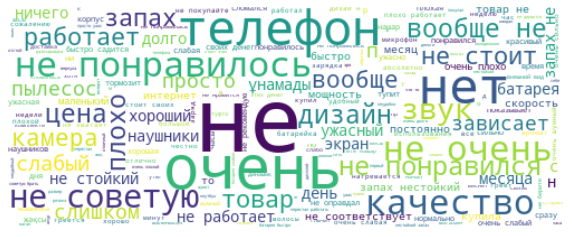

In [ ]:
negative = working_data[working_data['rating'] == 1]['only_text'].to_string().lower()
print_cloud(negative)

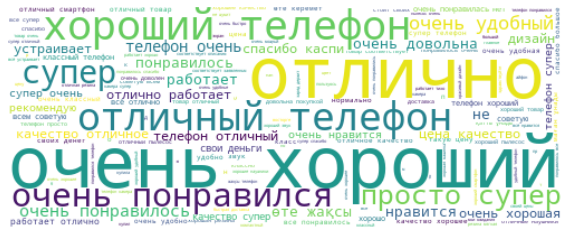

In [ ]:
positive = working_data[working_data['rating'] == 5]['only_text'].to_string().lower()
print_cloud(positive)

In [ ]:
params_grid_vectorizer = {
    'vectorizer__max_df' : [0.85, 0.9, 0.95, 1.0],
    'vectorizer__min_df' : [1, 10, 20], 
    'vectorizer__ngram_range' : [(1, 1), (1, 2), (1, 3), (1, 4), (1, 5), (1, 6)],
}


def make_pipeline(vectorizer, transformer, classifier):
    return Pipeline([
            ('vectorizer', vectorizer),
            ('transformer', transformer),
            ('classifier', classifier)
        ])

def make_estimator(classifier, params_grid, scorer, data, labels):
    pipeline = make_pipeline(CountVectorizer(), TfidfTransformer(), classifier)
    grid_cv = RandomizedSearchCV(pipeline, params_grid, scoring=scorer, cv=5, random_state=777, n_iter=10)
    grid_cv.fit(data, labels)
    return grid_cv

class DenseTransformer(TransformerMixin):
    def transform(self, X, y=None, **fit_params):
        return X.todense()

    def fit_transform(self, X, y=None, **fit_params):
        self.fit(X, y, **fit_params)
        return self.transform(X)

    def fit(self, X, y=None, **fit_params):
        return self

#### Введем 3 класса : positive, neutral и negative

In [ ]:
def sentimenting(x):
    if x>=4:
      return 'positive'
    if x>=3 and x<4:
      return 'neutral'
    if x<3:
      return 'negative'

In [ ]:
data['rating'] = data['rating'].apply(sentimenting)

In [ ]:
working_columns = ['only_text','rating']
working_data = data[working_columns]

In [ ]:
len(working_data)
working_data.dropna(subset = ['rating'], inplace=True) # не забываем убрать null

In [ ]:
working_data.shape

(199687, 2)

Сбалансируем классы

In [ ]:
working_data[working_data['rating'] == 'positive'].shape

(185521, 2)

In [ ]:
working_data[working_data['rating'] == 'neutral'].shape

(6390, 2)

In [ ]:
working_data[working_data['rating'] == 'negative'].shape

(7776, 2)

In [ ]:
undersample = working_data[working_data['rating'] == 'positive'].sample(7000, random_state=42)
working_data_undersampl = pd.concat([undersample,working_data[working_data['rating'] == 'neutral'],working_data[working_data['rating'] == 'negative']], axis=0)
working_data_undersampl.shape

(21166, 2)

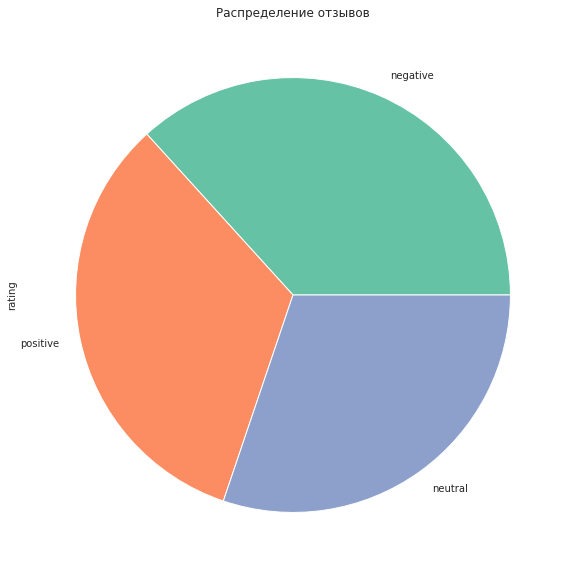

In [ ]:
fig = plt.figure(figsize=(12, 10))
working_data_undersampl['rating'].value_counts(normalize=True).plot(kind='pie')
plt.title("Распределение отзывов")
plt.show()

In [ ]:
print(working_data_undersampl.shape)
working_data_undersampl.dropna(inplace=True)
print(working_data_undersampl.shape)

(21166, 2)
(21121, 2)


Найдем отызвы на казахском

In [ ]:
count = 0
kaz_idxs =[]
for i in range(len(working_data_undersampl['only_text'])):
    for j in ['ә', 'і', 'ө', 'ұ', 'ү', 'ғ', 'қ', 'һ', 'ң']:
        if j in working_data_undersampl['only_text'].iloc[i] and i not in kaz_idxs:
            kaz_idxs.append(i)
            count+=1

In [ ]:
working_data_undersampl.iloc[kaz_idxs].sample(10)

,only_text,rating
106704,"сапасы нашар, қатты сормайды.",negative
28077,өте жақсы. бағасы қолжетімді. есігі бұрынғы үл...,positive
147681,"взяла мужу время каспи жұма, устраивает, телеф...",positive
194744,"сағатпен шомыла алмайсың, кинен барымалары бір...",neutral
140703,"батареясы жаксы, камерасы анық, бағасы 10 мың-...",positive
45329,жақсы.диск салатын жері жоқ екен!,neutral
125271,маған мүлде ұнамады,negative
154374,аккумулятор әлсіздеу. белсенді қолданғанда 8 с...,neutral
190686,дұрыс емес,neutral
139424,"заряда шыдамайды, тез өледі. көп интернетте от...",negative


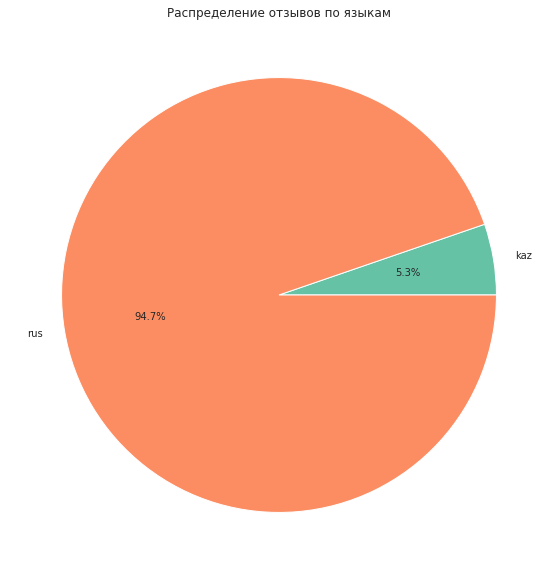

In [ ]:
labels = 'kaz', 'rus'
sizes = [count,working_data_undersampl.shape[0] - count]

fig1, ax1 = plt.subplots(figsize=(12,10))
plt.title("Распределение отзывов по языкам")
ax1.pie(sizes, labels=labels, autopct='%1.1f%%')


plt.show()

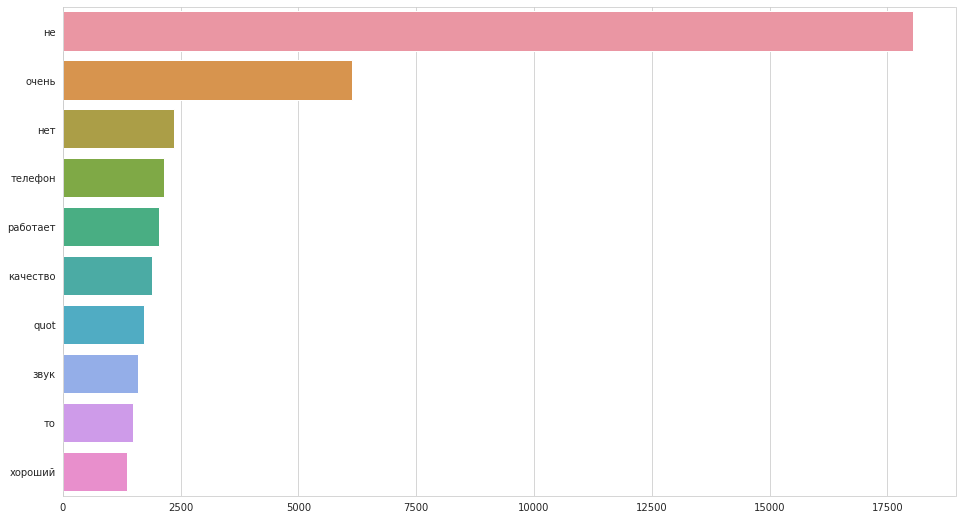

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
def get_top_text_ngrams(corpus, n, g):
    vec = CountVectorizer(ngram_range=(g, g)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]


df = working_data_undersampl[['only_text', 'rating']]

plt.figure(figsize = (16,9))
most_common_uni = get_top_text_ngrams(df.only_text,10,1)
most_common_uni = dict(most_common_uni)
sns.barplot(x=list(most_common_uni.values()),y=list(most_common_uni.keys()));

In [ ]:
from sklearn.metrics import f1_score
from sklearn.metrics import make_scorer


X_train, X_test, y_train, y_test = train_test_split(working_data_undersampl['only_text'], working_data_undersampl['rating'], test_size=0.33, random_state=42)

print('accuracy scores:')
for name, clf in {'LogisticRegression': LogisticRegression, 'LinearSVC': LinearSVC, 
               'SGDClassifier': SGDClassifier}.items():
    score = cross_val_score(make_pipeline(CountVectorizer(), TfidfTransformer(), clf(random_state=777)), X_train, y_train, cv=5).mean()
    print(f"{name} - {score}")


f1_scorer = make_scorer(f1_score, average = 'macro')

print('f1 scores:')
for name, clf in {'LogisticRegression': LogisticRegression, 'LinearSVC': LinearSVC, 
               'SGDClassifier': SGDClassifier}.items():
     score = cross_val_score(make_pipeline(CountVectorizer(), TfidfTransformer(), clf(random_state=777)), X_train, y_train, cv=5,scoring = f1_scorer).mean()
     print(f"{name} - {score}")

accuracy scores:
LogisticRegression - 0.6908347136011823
LinearSVC - 0.6735210996875831
SGDClassifier - 0.6846867280849456
f1 scores:
LogisticRegression - 0.6814054347017912
LinearSVC - 0.6633581400946605
SGDClassifier - 0.6676948917846304


In [ ]:
from sklearn.naive_bayes import MultinomialNB, BernoulliNB, GaussianNB

print('accuracy scores:')
for name, clf in {'MultinomialNB': MultinomialNB, 'BernoulliNB': BernoulliNB, 
               'GaussianNB': GaussianNB}.items():
    if name == 'GaussianNB':
        score = cross_val_score(Pipeline([('vectorizer', CountVectorizer()), ('transformer', TfidfTransformer()),
                                  ('dense', DenseTransformer()), ('classifier', GaussianNB())]), X_train, y_train, cv=5).mean()
    else:
        score = cross_val_score(make_pipeline(CountVectorizer(), TfidfTransformer(), clf()), X_train, y_train, cv=5).mean()
    print(f"{name} - {score}")

f1_scorer = make_scorer(f1_score, average = 'macro')


print('f1 scores:')
for name, clf in {'MultinomialNB': MultinomialNB, 'BernoulliNB': BernoulliNB, 
               'GaussianNB': GaussianNB}.items():
    if name == 'GaussianNB':
        score = cross_val_score(Pipeline([('vectorizer', CountVectorizer()), ('transformer', TfidfTransformer()),
                                  ('dense', DenseTransformer()), ('classifier', GaussianNB())]), X_train, y_train, cv=5).mean()
    else:
        score = cross_val_score(make_pipeline(CountVectorizer(), TfidfTransformer(), clf()), X_train, y_train, cv=5,scoring = f1_scorer).mean()
    print(f"{name} - {score}")

accuracy scores:
MultinomialNB - 0.6674439353298226
BernoulliNB - 0.5106360299211281
GaussianNB - 0.47918809046235955
f1 scores:
MultinomialNB - 0.6291101417920882
BernoulliNB - 0.4668853474128432
GaussianNB - 0.47918809046235955


Настроим параметры

In [ ]:
from sklearn.metrics import f1_score
from sklearn.metrics import make_scorer
from sklearn.model_selection import train_test_split


X_train, X_test, y_train, y_test = train_test_split(working_data_undersampl['only_text'], working_data_undersampl['rating'], test_size=0.33, random_state=42)

params_grid_lr = {
    'classifier__C': np.arange(0.1, 2, 0.1),
    'classifier__C': np.arange(0.1, 2, 0.5)
    'classifier__solver': ['lbfgs', 'liblinear', 'sag']
}


grid_search_lr = make_estimator(LogisticRegression(random_state=777), 
                                {**params_grid_vectorizer, **params_grid_lr}, 'accuracy', X_train, y_train)
print("LogisticRegression:")
print(f"Лучшее качество - {grid_search_lr.best_score_}")
print(f"Параметры - {grid_search_lr.best_params_}")
print(f"Качество на отложенной выборке - {accuracy_score(y_test,grid_search_lr.best_estimator_.predict(X_test))}")
print(f"Качество на отложенной выборке(f1score) - {f1_score(y_test,grid_search_lr.best_estimator_.predict(X_test),average='macro')}")

LogisticRegression:
Лучшее качество - 0.6952868606405858
Параметры - {'vectorizer__ngram_range': (1, 2), 'vectorizer__min_df': 10, 'vectorizer__max_df': 0.9, 'classifier__C': 1.1}
Качество на отложенной выборке - 0.6929698708751794
Качество на отложенной выборке(f1score) - 0.6841678494616699


In [ ]:
params_grid_lsvc = {
    'classifier__loss': ['hinge', 'squared_hinge'], 
    'classifier__max_iter': np.arange(100, 1000, 50),
    'classifier__tol': [1e-5, 1e-4, 1e-3],
    'classifier__C': np.arange(0.1, 2, 0.1)
}


grid_search_lsvc = make_estimator(LinearSVC(random_state=777), 
                                  {**params_grid_vectorizer, **params_grid_lsvc}, 'accuracy', X_train, y_train)
print("LinearSVC:")
print(f"Лучшее качество - {grid_search_lsvc.best_score_}")
print(f"Параметры - {grid_search_lsvc.best_params_}")
print(f"Качество на отложенной выборке - {accuracy_score(y_test,grid_search_lsvc.best_estimator_.predict(X_test))}")
print(f"Качество на отложенной выборке(f1score) - {f1_score(y_test,grid_search_lsvc.best_estimator_.predict(X_test),average='macro')}")

LinearSVC:
Лучшее качество - 0.6916122485405773
Параметры - {'vectorizer__ngram_range': (1, 2), 'vectorizer__min_df': 1, 'vectorizer__max_df': 1.0, 'classifier__tol': 1e-05, 'classifier__max_iter': 250, 'classifier__loss': 'squared_hinge', 'classifier__C': 1.5000000000000002}
Качество на отложенной выборке - 0.6946915351506456
Качество на отложенной выборке(f1score) - 0.6837686102490369


In [ ]:
params_grid_sgdc = {
    'classifier__loss': ['log', 'hinge', 'modified_huber'], 
    'classifier__penalty':  ['l1', 'l2', 'elasticnet'], 
    'classifier__max_iter': np.arange(100, 1000, 50),
    'classifier__tol': np.arange(1e-5, 1e-3, 1e-5)
}


grid_search_sgdc = make_estimator(SGDClassifier(random_state=777), 
                                  {**params_grid_vectorizer, **params_grid_sgdc}, 'accuracy', X_train, y_train)
print("SGDClassifier:")
print(f"Лучшее качество - {grid_search_sgdc.best_score_}")
print(f"Параметры - {grid_search_sgdc.best_params_}")
print(f"Качество на отложенной выборке - {accuracy_score(y_test,grid_search_sgdc.best_estimator_.predict(X_test))}")
print(f"Качество на отложенной выборке(f1score) - {f1_score(y_test,grid_search_sgdc.best_estimator_.predict(X_test),average='macro')}")

SGDClassifier:
Лучшее качество - 0.6969826242272268
Параметры - {'vectorizer__ngram_range': (1, 4), 'vectorizer__min_df': 10, 'vectorizer__max_df': 0.85, 'classifier__tol': 0.0003600000000000001, 'classifier__penalty': 'elasticnet', 'classifier__max_iter': 300, 'classifier__loss': 'log'}
Качество на отложенной выборке - 0.6934002869440459
Качество на отложенной выборке(f1score) - 0.6782267245388715


In [ ]:
from sklearn.naive_bayes import MultinomialNB, BernoulliNB, GaussianNB


params_grid_mnb = {
    'classifier__alpha': np.logspace(0, 5, 100), 
    'classifier__fit_prior': [True, False]
}


grid_search_mnb = make_estimator(MultinomialNB(), 
                                {**params_grid_vectorizer, **params_grid_mnb}, 'accuracy', X_train, y_train)
print("MultinomialNB:")
print(f"Лучшее качество - {grid_search_mnb.best_score_}")
print(f"Параметры - {grid_search_mnb.best_params_}")
print(f"Качество на отложенной выборке - {accuracy_score(y_test,grid_search_mnb.best_estimator_.predict(X_test))}")
print(f"Качество на отложенной выборке(f1score) - {f1_score(y_test,grid_search_mnb.best_estimator_.predict(X_test),average='macro')}")

MultinomialNB:
Лучшее качество - 0.6853940659507997
Параметры - {'vectorizer__ngram_range': (1, 2), 'vectorizer__min_df': 20, 'vectorizer__max_df': 0.95, 'classifier__fit_prior': False, 'classifier__alpha': 2.0092330025650473}
Качество на отложенной выборке - 0.681348637015782
Качество на отложенной выборке(f1score) - 0.6750948950320977


Попробуем деревья

In [ ]:
for name, clf in {'DecisionTreeClassifier': DecisionTreeClassifier, 'RandomForestClassifier': RandomForestClassifier, 
               'BaggingClassifier': BaggingClassifier}.items():
    score = cross_val_score(make_pipeline(CountVectorizer(), TfidfTransformer(), clf(random_state=777)), X_train, y_train, cv=5).mean()
    print(f"{name} - {score}")


f1_scorer = make_scorer(f1_score, average = 'macro')


for name, clf in {'DecisionTreeClassifier': DecisionTreeClassifier, 'RandomForestClassifier': RandomForestClassifier, 
               'BaggingClassifier': BaggingClassifier}.items():
     score = cross_val_score(make_pipeline(CountVectorizer(), TfidfTransformer(), clf(random_state=777)), X_train, y_train, cv=5,scoring = f1_scorer).mean()
     print(f"{name} - {score}")
  

DecisionTreeClassifier - 0.610887387250781
RandomForestClassifier - 0.6798532687889678
BaggingClassifier - 0.6469923929854984
DecisionTreeClassifier - 0.6026248541349244
RandomForestClassifier - 0.6587374889838263
BaggingClassifier - 0.6359488069380101


In [ ]:
params_grid_dtc = {
    'classifier__max_depth': np.arange(1, 30, 1),
    'classifier__min_samples_split': np.arange(2, 6, 1),
    'classifier__min_samples_leaf': [1, 2, 3],
    'classifier__min_impurity_decrease': np.logspace(-10, -6, 5)
}


grid_search_dtc = make_estimator(DecisionTreeClassifier(random_state=777), 
                                {**params_grid_vectorizer, **params_grid_dtc}, 'accuracy', X_train, y_train)
print("DecisionTreeClassifier:")
print(f"Лучшее качество - {grid_search_dtc.best_score_}")
print(f"Параметры - {grid_search_dtc.best_params_}")
print(f"Качество на отложенной выборке - {accuracy_score(y_test,grid_search_dtc.best_estimator_.predict(X_test))}")

DecisionTreeClassifier:
Лучшее качество - 0.5718210350531188
Параметры - {'vectorizer__ngram_range': (1, 4), 'vectorizer__min_df': 20, 'vectorizer__max_df': 0.85, 'classifier__min_samples_split': 5, 'classifier__min_samples_leaf': 2, 'classifier__min_impurity_decrease': 1e-07, 'classifier__max_depth': 15}
Качество на отложенной выборке - 0.5775232641374374


In [ ]:
params_grid_rfc = {
    'classifier__n_estimators': np.arange(1, 30, 1),
    'classifier__max_depth': [None] + list(np.arange(1, 30, 1)),
    'classifier__min_samples_split': np.arange(2, 6, 1),
    'classifier__min_samples_leaf': [1, 2, 3],
    'classifier__max_features': ['auto', 'sqrt', 'log2'],
    'classifier__min_impurity_decrease': np.logspace(-10, -6, 5)
}


grid_search_rfc = make_estimator(RandomForestClassifier(random_state=777), 
                                {**params_grid_vectorizer, **params_grid_rfc}, 'accuracy', X_train, y_train)
print("RandomForestClassifier:")
print(f"Лучшее качество - {grid_search_rfc.best_score_}")
print(f"Параметры - {grid_search_rfc.best_params_}")
print(f"Качество на отложенной выборке - {accuracy_score(y_test,grid_search_rfc.best_estimator_.predict(X_test))}")
print(f"Качество на отложенной выборке(f1score) - {f1_score(y_test,grid_search_rfc.best_estimator_.predict(X_test),average='macro')}")

RandomForestClassifier:
Лучшее качество - 0.6022191961037129
Параметры - {'vectorizer__ngram_range': (1, 3), 'vectorizer__min_df': 10, 'vectorizer__max_df': 1.0, 'classifier__n_estimators': 26, 'classifier__min_samples_split': 2, 'classifier__min_samples_leaf': 2, 'classifier__min_impurity_decrease': 1e-07, 'classifier__max_features': 'auto', 'classifier__max_depth': 17}
Качество на отложенной выборке - 0.5923959827833573
Качество на отложенной выборке(f1score) - 0.49120133251954085


Посмотрим на работу моделей

Logistic regression

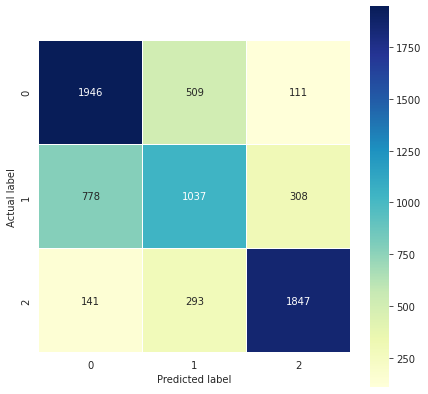

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics


cm = metrics.confusion_matrix(y_test,grid_search_lr.best_estimator_.predict(X_test))
plt.figure(figsize=(7,7))
sns.heatmap(cm, annot=True, fmt=".0f", linewidths=.5, square = True, cmap = 'YlGnBu');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
plt.savefig("LR_tfidf.png")

SVM

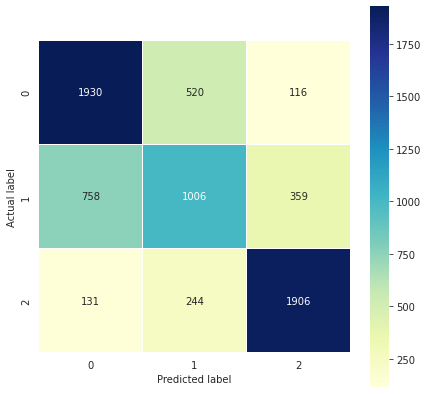

In [ ]:
cm = metrics.confusion_matrix(y_test,grid_search_lsvc.best_estimator_.predict(X_test))
plt.figure(figsize=(7,7))
sns.heatmap(cm, annot=True, fmt=".0f", linewidths=.5, square = True, cmap = 'YlGnBu');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
plt.savefig("SVM_tfidf.png")

MultinomialNB

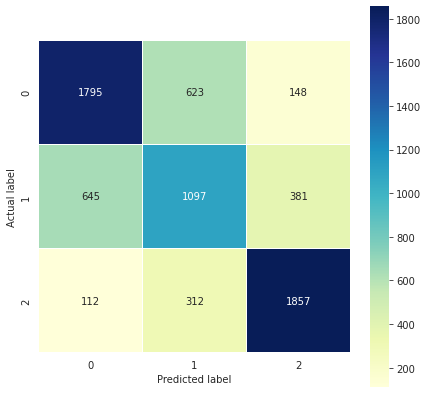

In [ ]:
cm = metrics.confusion_matrix(y_test,grid_search_mnb.best_estimator_.predict(X_test))
plt.figure(figsize=(7,7))
sns.heatmap(cm, annot=True, fmt=".0f", linewidths=.5, square = True, cmap = 'YlGnBu');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
plt.savefig("MNB_tfidf.png")

RandomForest

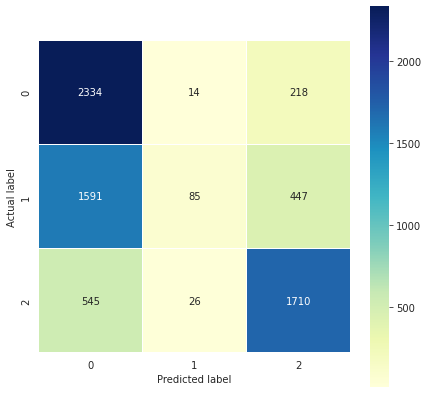

In [ ]:
cm = metrics.confusion_matrix(y_test,grid_search_rfc.best_estimator_.predict(X_test))
plt.figure(figsize=(7,7))
sns.heatmap(cm, annot=True, fmt=".0f", linewidths=.5, square = True, cmap = 'YlGnBu');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
plt.savefig("RF_tfidf.png")